In [1]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for Data
#import yfinance as yf

In [2]:
# Extract Raw data
PATH = os.path.expanduser("~/investor/data/raw")
all_files = glob.glob(os.path.join(PATH , "*.csv"))

all_df = []

for filename in all_files:
    file = pd.read_csv(filename, index_col=None, header=0)
    all_df.append(file)
    
df = pd.concat(all_df, axis=0, ignore_index=True)

# Renaming the columns by removing the '<' and '>' characters
new_column_names = {col: col.strip('<>').upper() for col in df.columns}
df = df.rename(columns=new_column_names)

# changing the integer dates to datetime format, taking 2002- NOW:
df = df[np.logical_and(df['DATE'] <= '2024-01-01', df['DATE'] > '2001-12-31')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5537 entries, 0 to 5536
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    5537 non-null   object 
 1   OPEN    5537 non-null   float64
 2   HIGH    5537 non-null   float64
 3   LOW     5537 non-null   float64
 4   CLOSE   5537 non-null   float64
 5   VOLUME  5537 non-null   float64
dtypes: float64(5), object(1)
memory usage: 302.8+ KB


In [3]:
# OHLC prices: These are essential for technical analysis and commonly used to derive various technical indicators.
# Volume: Trading volume provides insights into market activity and liquidity.
# Calculate discrete returns
# df['discrete_return'] = (df['CLOSE'] - df['CLOSE'].shift(1)) / df['CLOSE'].shift(1)
df['discrete_return'] = np.log(df['OPEN']/df['OPEN'].shift(1)) # opposed to closing prices, to avoid look-ahead bias.

print(df.describe())
df.head()

              OPEN         HIGH          LOW        CLOSE        VOLUME  \
count  5537.000000  5537.000000  5537.000000  5537.000000  5.537000e+03   
mean   2032.993224  2044.721345  2020.494185  2033.362093  1.952158e+09   
std    1087.570787  1093.190057  1081.683342  1087.803827  7.841206e+08   
min     679.280000   695.270000   666.790000   676.530000  1.978167e+08   
25%    1191.380000  1198.620000  1184.490000  1191.500000  1.480139e+09   
50%    1525.100000  1532.400000  1518.750000  1525.400000  1.965294e+09   
75%    2712.400000  2728.090000  2696.880000  2711.450000  2.355871e+09   
max    4804.510000  4818.620000  4780.980000  4796.560000  6.364572e+09   

       discrete_return  
count      5536.000000  
mean          0.000258  
std           0.011302  
min          -0.091150  
25%          -0.004285  
50%           0.000773  
75%           0.005552  
max           0.101394  


,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,discrete_return
0,2002-01-02,1148.08,1154.67,1136.23,1154.67,650555556.0,NaN
1,2002-01-03,1154.67,1165.27,1154.01,1165.27,777166667.0,0.005724
2,2002-01-04,1165.27,1176.55,1163.42,1172.51,840555556.0,0.009138
3,2002-01-07,1172.51,1176.97,1163.55,1164.89,726833333.0,0.006194
4,2002-01-08,1164.89,1167.60,1157.46,1160.71,699333333.0,-0.006520


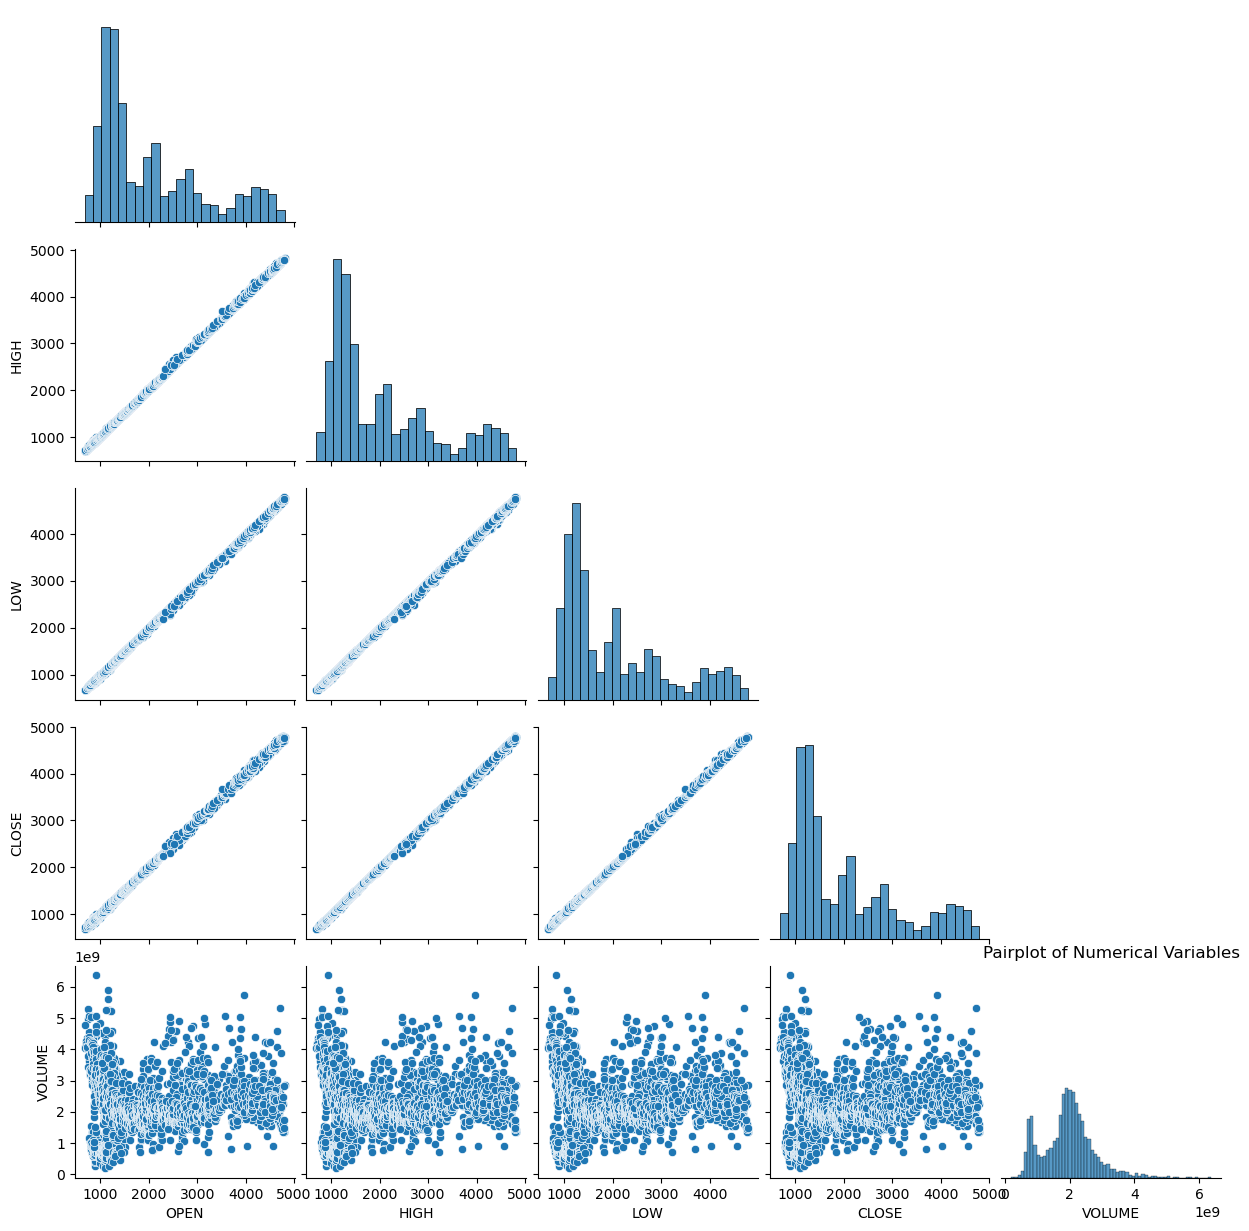

In [4]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']], corner=True)
plt.title('Pairplot of Numerical Variables')
plt.show()

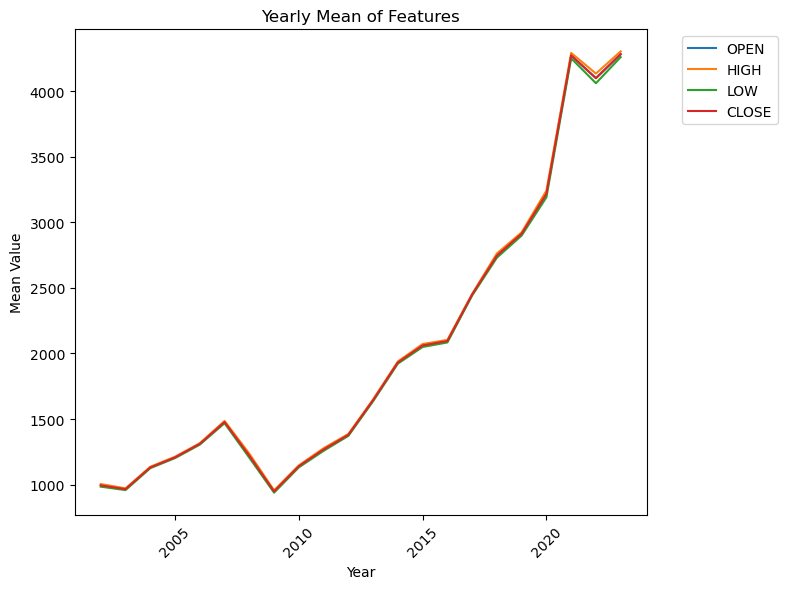

In [5]:
df_A = df.copy()
df_A['DATE'] = pd.to_datetime(df_A['DATE'])

# Extract year from the 'DATE' column
df_A['Year'] = df_A['DATE'].dt.year

# Aggregate data by year and compute the mean for each feature
yearly_data = df_A[['Year','OPEN', 'HIGH', 'LOW', 'CLOSE']].groupby('Year').mean()

# Reset index to have 'Year' as a regular column
yearly_data.reset_index(inplace=True)

# Melt the DataFrame to have a single x-axis for all features
melted_yearly_data = yearly_data.melt(id_vars=['Year'], var_name='Feature', value_name='Mean Value')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_yearly_data, x='Year', y='Mean Value', hue='Feature')
plt.title('Yearly Mean of Features')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
import requests

from bokeh.plotting import figure
from bokeh.palettes import Category20
from bokeh.models.widgets import PreText
from bokeh.models import BooleanFilter, CDSView, BoxAnnotation, Band, Span, Select, LinearAxis, DataRange1d, Range1d
from bokeh.models.formatters import PrintfTickFormatter, NumeralTickFormatter

WIDTH_PLOT = 1500

RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

TOOLS = 'pan,wheel_zoom,reset'

# Main chart for stock prices with candlestick and Bolinger bands
def plot_stock_price(stock):
    p = figure(x_axis_type="datetime", plot_width=WIDTH_PLOT, plot_height=400,
               title="Stock price + Bollinger Bands (2 std)",
               tools=TOOLS, toolbar_location='above')
    # Data Filtering: It separates the data into two categories: increasing prices ..
    # (inc) and decreasing prices (dec) based on whether the closing price is greater than
    # the opening price.
    inc = df['CLOSE'] > df['OPEN']
    dec = df['OPEN'] > df['CLOSE']
    view_inc = CDSView(source=df, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=df, filters=[BooleanFilter(dec)])

    width = 35000000

    p.segment(x0='date', x1='date', y0='low', y1='high', color=RED, source=stock, view=view_inc)
    p.segment(x0='date', x1='date', y0='low', y1='high', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='date', width=width, top='open', bottom='close', fill_color=RED, line_color=RED,
           source=stock,
           view=view_inc)
    p.vbar(x='date', width=width, top='open', bottom='close', fill_color=GREEN, line_color=GREEN,
           source=stock,
           view=view_dec)

    # p.line(x='date', y='close_line', line_width=1, color=BLUE, line_alpha=0.7, souce=stock)

    band = Band(base='date', lower='bolling_lower', upper='bolling_upper', source=stock, level='underlay',
                fill_alpha=0.5, line_width=1, line_color='black', fill_color=BLUE_LIGHT)
    p.add_layout(band)

    code = """
    def ticker():
        return "{:.0f} + {:.2f}".format(tick, tick % 1)
    """
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')

    return p

In [6]:
#Simple Moving Avarage 
window_size = 15
#SMA Signal = Pt(current price as close price) - SMA
SMA =  df['CLOSE'].rolling(window=window_size).mean()
SMA_signal = df['CLOSE'] - SMA

In [7]:
#Weighted Moving Average
def calculate_wma(data, window):
    weights = np.arange(1, window + 1)
    wma = data.rolling(window=window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

In [8]:

# Define the window size for WMA calculation
window_size = 15

# Calculate WMA with the specified window size
WMA = calculate_wma(df['CLOSE'], window_size)

WMA_signal = df['CLOSE'] - WMA

In [9]:

# Define the window size for EMA calculation
window_size = 15

# Calculate EMA with the specified window size
#α = 2 / (N + 1)
EMA = df['CLOSE'].ewm(span=window_size).mean()

EMA_signal = df['CLOSE'] - EMA

In [10]:
#Moving Average Convergence Divergence (MACD)
# Define periods for short-term and long-term EMAs
short_period = 12
long_period = 26
signal_line_span = 9

# Calculate short-term EMA
short_ema = df['CLOSE'].ewm(span=short_period, adjust=False).mean()

# Calculate long-term EMA
long_ema = df['CLOSE'].ewm(span=long_period, adjust=False).mean()

# Calculate MACD line
macd_line = short_ema - long_ema

# Calculate Signal line (typically 9-period EMA of MACD line)
signal_line = macd_line.ewm(span=signal_line_span, adjust=False).mean()

# Calculate MACD signal
macd_signal = macd_line - signal_line

In [116]:
# Define periods for calculating highest high and lowest low
window_size = 14

# Calculate highest high and lowest low over the period
HH = df['HIGH'].rolling(window=window_size).max()
LL = df['LOW'].rolling(window=window_size).min()

# Calculate %K line for Fast Stochastic Oscillator
K_Fast = 100 * ((df['CLOSE'] - LL) / (HH - LL))

# Calculate %D line for Fast Stochastic Oscillator (typically a 3-period SMA of %K)
period_d_fast = 3
D_Fast = K_Fast.rolling(window=period_d_fast).mean()

# Calculate %K line for Slow Stochastic Oscillator
# This is not a feture as suggested by the article 
period_slow = 3
K_Slow = K_Fast.rolling(window=period_slow).mean()

# Calculate %D line for Slow Stochastic Oscillator (typically a 3-period SMA of %K_Slow)
period_d_slow = 3
D_Slow = K_Slow.rolling(window=period_d_slow).mean()

In [117]:
#Need to validate this code 
#Relative Strength Index (RSI)
window_size = 14

# Calculate price changes
Price_Change = df['CLOSE'].diff()

# Calculate gains and losses
Gain = np.where(Price_Change > 0, Price_Change, 0)
Loss = np.where(Price_Change < 0, abs(Price_Change), 0)

# Calculate average gain and average loss over the period
Avg_Gain = pd.Series(Gain).rolling(window=window_size, min_periods=1).mean()
Avg_Loss = pd.Series(Loss).rolling(window=window_size, min_periods=1).mean()

# Calculate Relative Strength (RS)
RS = Avg_Gain / Avg_Loss

# Calculate RSI
RSI = 100 - (100 / (1 + RS))

In [118]:
rsi_values = []
window_size = 14
for i in range(window_size, len(df['CLOSE'])):
    gains = [df['CLOSE'][j - 1] - df['CLOSE'][j] for j in range(i - (window_size - 1), i) if df['CLOSE'][j - 1] > df['CLOSE'][j]]
    losses = [-1 * (df['CLOSE'][j - 1] - df['CLOSE'][j]) for j in range(i - (window_size - 1), i) if df['CLOSE'][j - 1] < df['CLOSE'][j]]

    avg_gain = sum(gains) / window_size if gains else 0
    avg_loss = sum(losses) / window_size if losses else 0

    if avg_loss == 0:
        rsi = 100
    else:
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
    
    rsi_values.append(rsi)

In [119]:
# Define period for WPR calculation
window_size = 14

# Calculate highest high and lowest low over the period
Highest_High = df['HIGH'].rolling(window=window_size).max()
Lowest_Low = df['LOW'].rolling(window=window_size).min()

# Calculate Williams %R
WPR = (Highest_High - df['CLOSE']) / (Highest_High - Lowest_Low) * -100


In [120]:
type(WPR)

pandas.core.series.Series